In [1]:
import pandas as pd
import sqlite3

In [2]:
connection = sqlite3.connect('C:/Users/alqai/Downloads/Code _ Data/checkouts.db')

In [3]:
cursor = connection.cursor()

### Query to look at the tables in the db

In [4]:
pd.read_sql_query('SELECT * FROM sqlite_master WHERE type = "table"', connection)

,type,name,tbl_name,rootpage,sql
0,table,kz,kz,64992,"CREATE TABLE ""kz"" (\n\t""event_time""\tTEXT,\n\t..."
1,table,checkout,checkout,183424,"CREATE TABLE ""checkout"" (\n\t""event_time""\tTEX..."


###  Check the table columns, data types


In [6]:
table_info = ('SELECT *, type FROM pragma_table_info("checkout")')

pd.read_sql_query(table_info, connection)

,cid,name,type,notnull,dflt_value,pk,type
0,0,event_time,TEXT,0,None,0,TEXT
1,1,order_id,INTEGER,1,None,0,INTEGER
2,2,product_id,TEXT,0,None,0,TEXT
3,3,category_id,TEXT,0,None,0,TEXT
4,4,category_code,text,0,None,0,text
5,5,brand,text,0,None,0,text
6,6,price,INTEGER,0,None,0,INTEGER
7,7,user_id,INTEGER,0,None,0,INTEGER


### Explore the checkout table  


In [7]:
df = pd.read_sql_query("SELECT * FROM checkout LIMIT 5000", connection)
df.head(5)

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2294359932054536960,1515966223509089906,2.26810542664817e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2294359932054536960,1515966223509089906,2.26810542664817e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43 UTC,2294444024058086144,2273948319057183658,2.268105430163e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24 14:37:43 UTC,2294444024058086144,2273948319057183658,2.268105430163e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24 19:16:21 UTC,2294584263154074112,2273948316817424439,2.26810547136784e+18,None,karcher,217.57,1.515916e+18


### Table data types

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_time     5000 non-null   object 
 1   order_id       5000 non-null   int64  
 2   product_id     5000 non-null   object 
 3   category_id    4997 non-null   object 
 4   category_code  3946 non-null   object 
 5   brand          4800 non-null   object 
 6   price          4997 non-null   float64
 7   user_id        4997 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 312.6+ KB


### Check duplicates

In [9]:
cursor.execute('''SELECT order_id FROM checkout WHERE 
order_id IN (SELECT order_id FROM checkout) GROUP BY order_id''').fetchmany()

[(2294359932054536960,)]

### Display number_of_orders, 	minmum_price,	max_price,	total_sales	, average_price


In [10]:
g =('''SELECT COUNT(DISTINCT order_id) as number_of_orders,MIN(price) as minmum_price,
               MAX(price) as max_price, ROUND(SUM(price)) as total_sales,
               AVG(price) as average_price FROM checkout WHERE price > 0''')
pd.read_sql_query(g, connection)

,number_of_orders,minmum_price,max_price,total_sales,average_price
0,1097351,0.02,50925.9,339246428.0,154.101635


### Calculating the median price


In [11]:

median = ('''SELECT price as median_price FROM checkout ORDER BY price
LIMIT 1 OFFSET(SELECT COUNT(*) FROM checkout) / 2 ''')

pd.read_sql_query(median, connection)

,median_price
0,34.7


###  Highst price item sold


In [12]:
highst_item = ('''SELECT * 
FROM checkout
WHERE price = (SELECT max(price) FROM checkout)''')

highst_item_df = pd.read_sql_query(highst_item, connection)
highst_item_df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-05-26 08:12:38 UTC,2353234364520727552,1515966223509105016,2.37449891400059e+18,electronics.video.tv,samsung,50925.9,None


### Lowest price items


In [13]:
lowest_item = ('''SELECT DISTINCT* 
FROM checkout
WHERE price = (SELECT min(price) FROM checkout WHERE price >0)''')

lowest_item_df = pd.read_sql_query(lowest_item, connection)
lowest_item_df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-29 03:25:12 UTC,2297729407910937600,1515966223509105105,2.26810542752897e+18,None,sbs,0.02,1.515916e+18
1,2020-05-01 05:03:49 UTC,2299228597979709440,1515966223509262429,2.26810542726054e+18,None,ava,0.02,1.515916e+18
2,2020-05-01 08:08:36 UTC,2299321605823660800,1515966223509262429,2.26810542726054e+18,None,ava,0.02,1.515916e+18
3,2020-05-01 11:45:13 UTC,2299430630892503552,1515966223509616615,2.26810542726054e+18,None,ava,0.02,1.515916e+18
4,2020-05-01 19:24:14 UTC,2299661657258852864,2273948282508018619,2.26810542726054e+18,None,sbs,0.02,1.515916e+18


### Distinct users

In [14]:

cursor.execute('''SELECT COUNT(DISTINCT user_id) FROM checkout where user_id != "None"''').fetchall()

[(98262,)]

### Repeated customers


In [26]:
cursor.execute('''SELECT COUNT(user_id) AS repeated_customers FROM checkout WHERE 
user_id IN (SELECT user_id FROM checkout)''').fetchall()

[(564169,)]

### Count of orders per category


In [16]:
order_per_category = ('''SELECT category_code, COUNT( category_id)
FROM checkout GROUP BY category_code
ORDER BY COUNT(category_id) DESC''')

order_per_category_df = pd.read_sql_query(order_per_category, connection)
order_per_category_df.head()

,category_code,COUNT( category_id)
0,None,612202
1,electronics.smartphone,357682
2,appliances.kitchen.refrigerators,77386
3,electronics.video.tv,71711
4,computers.notebook,71436


### Where most of the sales is coming? by brand. 


In [17]:
per_brand = ('''SELECT brand,count(DISTINCT order_id) as orders_per_brand,
category_code, ROUND(SUM(price)) as sales
FROM checkout
group by brand, category_code
HAVING sales >1 AND brand !='None'
ORDER by sales DESC''')

per_brand_df = pd.read_sql_query(per_brand, connection)
per_brand_df.head()

,brand,orders_per_brand,category_code,sales
0,samsung,129649,electronics.smartphone,44984338.0
1,apple,33322,electronics.smartphone,35352547.0
2,samsung,17894,electronics.video.tv,12674670.0
3,lg,15297,electronics.video.tv,10499896.0
4,lenovo,13711,computers.notebook,10257374.0


###  Plot orders per brand

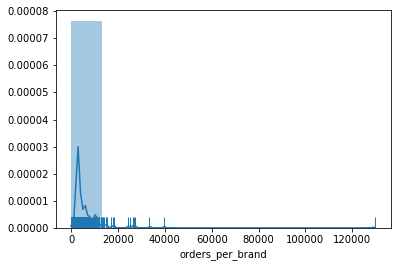

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#plot items_sold per brand to see the distribution
sns.distplot(per_brand_df['orders_per_brand'], bins = 10, rug = True )
# the number of items sold per brand is skewed to the right since mos of brands are concentrated
#around 0

### sales per brand 

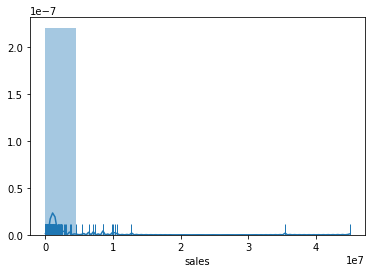

In [19]:
sns.distplot(per_brand_df['sales'], bins = 10, rug = True )


### Min category ordered 


In [20]:
##### tried where  category_code != 'int' and it gave me None

min_category = ('''SELECT min(mincount), category_code
FROM (SELECT category_code, COUNT(category_code) AS mincount FROM checkout GROUP BY category_code) 
where  category_code = 'apparel.shoes'
''')

min_category_df = pd.read_sql_query(min_category, connection)
min_category_df.head()

,min(mincount),category_code
0,2,apparel.shoes


### Top category ordered 


In [21]:
max_category= ('''SELECT MAX(maxcount), category_code
FROM (SELECT category_code, COUNT(category_code) AS maxcount FROM checkout GROUP BY category_code) 
''')

max_category_df = pd.read_sql_query(max_category, connection)
max_category_df.head()

,MAX(maxcount),category_code
0,357682,electronics.smartphone


### Check if there is any returns 


In [22]:
cursor.execute('''SELECT SUM(price) FROM checkout WHERE price <0''').fetchall()

[(None,)]